In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd


from rBoltzMach import boltzmanmachine
from metrics import pair_error, sequence_error, JS_divergence, p
from Graphics import distr_ami

plt.rcParams['font.size'] = 14

## Data selection

In [2]:
CASE=1           #select the data to be analysed
if CASE==0: dname="DATA"
if CASE==1: dname="DATA_b"
    
fname=dname+'/x_RBM_q0.1.dat'
v = np.loadtxt(fname, delimiter=" ",dtype=int)
v0 = np.copy(v)  #Copy original data to analyse later

In [3]:
perror = pair_error(v0, spin=False)
serror = sequence_error(v0, spin=False, vmin=0)
print(perror, serror)


9.457500000000001 22.6


In [4]:
JS_divergence(np.array([0.,0.,0.,0.]), np.array([0.25, 0.25, 0.25, 0.25]))

0.34657359027997264

## We want to build heat maps where we list our metrics as functions of the training and genereting temperature
Since for now we trained our bolzaman machine with tempratures that ranged from 0.05, to 0.5, we could build a matrix for each metrics containing their values, with the axes being the rows and columns

## Network parameters

In [5]:
seed = 1
N = len(v)       #Number of rows
L = len(v[0])    #Set the number of visible variable
M = 6            #Set the number of hidden units

sigma = np.sqrt(4. / float(L + M))

print(f'each of N={N} data has L={L} digits')
print(f'The network has {L} visible units and {M} hidden units')
print(f'Initializing std {sigma}')

each of N=10000 data has L=20 digits
The network has 20 visible units and 6 hidden units
Initializing std 0.3922322702763681


### Create a list with the file names containing the models

In [6]:
models_spin = ['Models/RMSprop_005_1_spin.npz',
              'Models/RMSprop_01_1_spin.npz',
              'Models/RMSprop_015_1_spin.npz',
              'Models/RMSprop_02_1_spin.npz',
              'Models/RMSprop_025_1_spin.npz',
              'Models/RMSprop_03_1_spin.npz',
              'Models/RMSprop_035_1_spin.npz',
              'Models/RMSprop_04_1_spin.npz',
              'Models/RMSprop_045_1_spin.npz',
              'Models/RMSprop_05_1_spin.npz']

models_names = ['Models/RMSprop_005_1.npz',
              'Models/RMSprop_01_1.npz',
              'Models/RMSprop_015_1.npz',
              'Models/RMSprop_02_1.npz',
              'Models/RMSprop_025_1.npz',
              'Models/RMSprop_03_1.npz',
              'Models/RMSprop_035_1.npz',
              'Models/RMSprop_04_1.npz',
              'Models/RMSprop_045_1.npz',
              'Models/RMSprop_05_1.npz']

amp_list = [0.05, 0.10, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

### Let's start by initialising the lists that will contain our metrics

In [7]:
pair_errors = np.zeros((len(models_spin),len(amp_list)))
sequence_errors = np.zeros((len(models_spin),len(amp_list)))
js_divergences = np.zeros((len(models_spin),len(amp_list)))

### Spin model metrics

In [8]:
starting_amp = 0.05

q = np.ones((5,4))*0.25 

for n_model in np.arange(1,len(models_spin)+1):
    print(f'{models_spin[n_model-1]:}', end='\t')
    for amp_k in np.arange(1,len(amp_list)+1):

        np.random.seed(seed)
        rbm = boltzmanmachine(L,M,sigma)
        rbm.load_model(models_spin[n_model-1])
        
        vf = rbm.gen_fantasy(v, starting_amp*amp_k)
        
        pair_errors[n_model-1, amp_k-1] = pair_error(vf, spin=True)
        sequence_errors[n_model-1, amp_k-1] = sequence_error(vf, spin=True)
        
        pr = np.reshape(p(vf), (5,4))
        js_divergences[n_model-1, amp_k-1] = JS_divergence(pr,q)
         
        print('.', end='')
    print( ' done')

Models/RMSprop_005_1_spin.npz	.......... done
Models/RMSprop_01_1_spin.npz	.......... done
Models/RMSprop_015_1_spin.npz	.......... done
Models/RMSprop_02_1_spin.npz	.......... done
Models/RMSprop_025_1_spin.npz	.......... done
Models/RMSprop_03_1_spin.npz	.......... done
Models/RMSprop_035_1_spin.npz	.......... done
Models/RMSprop_04_1_spin.npz	.......... done
Models/RMSprop_045_1_spin.npz	.......... done
Models/RMSprop_05_1_spin.npz	.......... done


### Saves computed on a .npz

In [15]:
np.savez('Models/Metrics_spin.npz', pair=pair_errors, seque=sequence_errors, js=js_divergences)

In [9]:
df_pair = pd.DataFrame(pair_errors, columns=amp_list, index=amp_list)
df_sequ = pd.DataFrame(sequence_errors, columns=amp_list, index=amp_list)
df_jsdi = pd.DataFrame(js_divergences, columns=amp_list, index=amp_list)

In [10]:
import seaborn as sns

[]

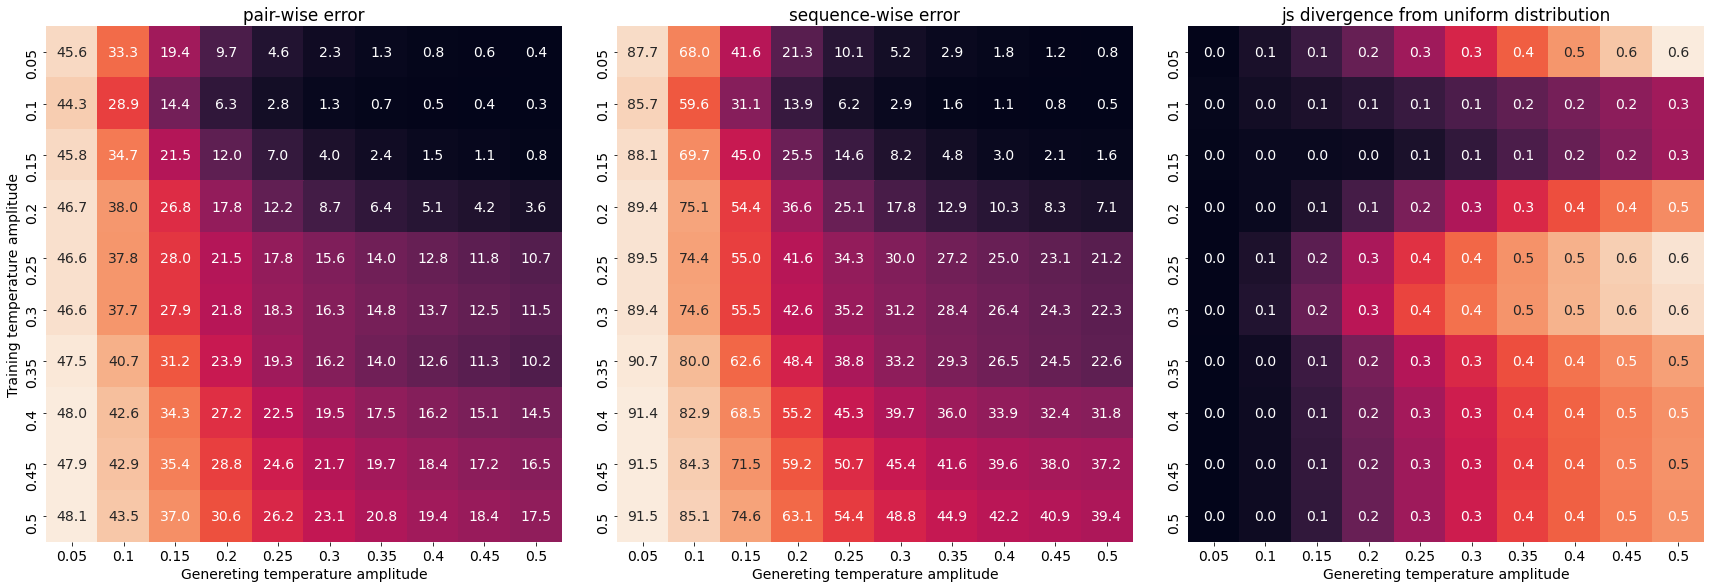

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,24))
fig.tight_layout()
sns.heatmap(ax=ax[0],data=df_pair,annot=True,fmt=".1f",cbar=False,square=True)
sns.heatmap(ax=ax[1],data=df_sequ,annot=True,fmt=".1f",cbar=False,square=True)
sns.heatmap(ax=ax[2],data=df_jsdi,annot=True,fmt=".1f",cbar=False,square=True)

ax[0].set_title('pair-wise error')
ax[0].set_ylabel('Training temperature amplitude')
ax[0].set_xlabel('Genereting temperature amplitude')

ax[1].set_title('sequence-wise error')
#ax[1].set_ylabel('Training temperature amplitude')
ax[1].set_xlabel('Genereting temperature amplitude')

ax[2].set_title('js divergence from uniform distribution')
#ax[2].set_ylabel('Training temperature amplitude')
ax[2].set_xlabel('Genereting temperature amplitude')
plt.plot()